# Create a Kaggle Workflow

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# import the Titanic data set
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

##  1. Preprocessing the data

In [2]:
# %load  functions.py
def process_missing(df):
    """
      Handle various missing values from the data set
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """
      Process the Age column into pre-defined 'bins' 
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """
      Process the Fare column into pre-defined 'bins' 
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """
      "Process the Cabin column into pre-defined 'bins' 
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """
      Extract and categorize the title from the name column 
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """
      Create Dummy Columns (One Hot Encoding) from a single Column
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_df(input_df): 
    df = process_missing(input_df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df,col)
    return df

train = process_df(train)
holdout  = process_df(holdout )

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Cabin_type          

## 2.Explore the data

Use pandas and matplotlib to explore SibSp and Parch columns.


In [4]:
explore_cols = ["SibSp","Parch"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


<AxesSubplot:ylabel='Frequency'>

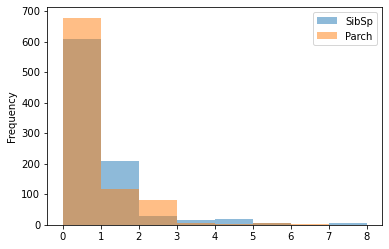

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.plot.hist(alpha=0.5,bins=8)

<AxesSubplot:ylabel='Frequency'>

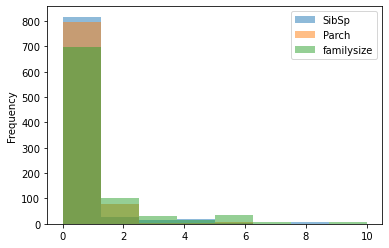

In [6]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.plot.hist(alpha=0.5,bins=8)

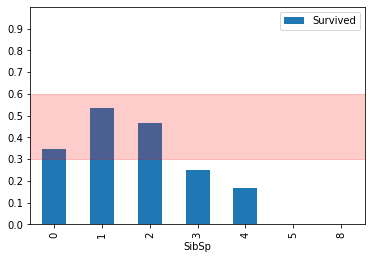

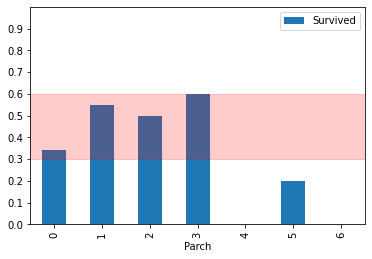

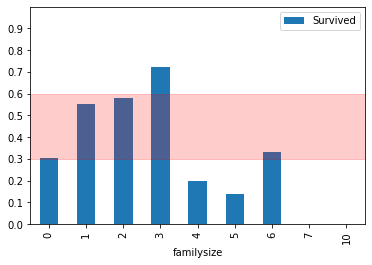

In [7]:
explore['Survived'] = train['Survived']

for col in explore.columns.drop('Survived'):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()



The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## 3. Enginnering New Features


In [8]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    return df
train = process_isalone(train)
holdout = process_isalone(holdout)   

## 4. Selecting the Best_Performing Features

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf =RandomForestClassifier(random_state = 1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)

    best_columns = all_X.columns[selector.support_]
    return best_columns

cols = select_features(train)
cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'familysize'],
      dtype='object')

## 5.Selecting and tuning differnet algorithms

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    
    models = [
    {
        "name": "LogisticRegression",
    	"estimator": LogisticRegression(),
    	"hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
    
        }
    },   
    {
        "name": "KNeighborsClassifier",
    	"estimator": KNeighborsClassifier(),
    	"hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
	},
	{
        "name": "RandomForestClassifier",
    	"estimator": RandomForestClassifier(),
    	"hyperparameters":
        {
            "n_estimators": [4, 6, 9],
			"criterion": ["entropy", "gini"],
			"max_depth": [2, 5, 10],
			"max_features": ["log2", "sqrt"],
			"min_samples_leaf": [1, 5, 8],
			"min_samples_split": [2, 3, 5]
        }
	}]
    
    for model in models:
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        print ("Best Model:" + str(grid.best_estimator_))
        print ("Best Score:" + str(grid.best_score_))
    return models

result = select_model(train,cols)

Best Model:LogisticRegression(solver='newton-cg')
Best Score:0.821598002496879
Best Model:KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7, p=1)
Best Score:0.7822971285892635
Best Model:RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_split=3, n_estimators=6)
Best Score:0.8383895131086143


## 6.Making a submmision on Kaggle

In [11]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)